In [2]:
import sys
sys.path.append(r'/home/tacuevas/github/ECE542_NCSU_projC')
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
import pickle
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
from utils import *

In [3]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathData = Path(r'/home/tacuevas/github/ECE542_NCSU_projC/TrainingData')
dctData = read_data(pathData)

In [4]:
## upsample labels using nearest neighbor
# dctUps = upsampleData(dctData)
with open(r'/mnt/drive1/Insyncs/NCSU/courses/ECE542/projC/upsampledDataset.pkl', 'rb') as fin:
    dctUps = pickle.load(fin)

In [5]:
## count number of timesteps for each session of each subject
dctClass = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for k in dctUps.keys():
    dfs = dctUps[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctClass[k].loc[s, aux.index] = aux.values

In [6]:
## get the number of instances for each to make the dataset balanced
## the first and second more frequents per session and individual are set to two times
## the third class in case they are larger. The mode is set as the same of the second 
## more repeated class
dctClassBal = balanceData(dctClass, 2)

In [7]:
## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}

testSessions = [(1,5), (2, 2), (3, 2), (4, 1), (5, 1), (6, 2), (7, 3)]
dctTest = {}

for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []

    for s in dfk['session'].unique():

        tup = (int(k.split('_')[1]), s)
        dfks = dfk[dfk['session'] == s]
        
        if tup in testSessions:
            dctTest[k] = dfks
            print(f'{k} session {s} for testing')
        else:
            print(f'{k} session {s} for training')
            nvalAll = dctClass[k].loc[s, :]
            nvalBall = dctClassBal[k].loc[s, :]
        
            out = []
            for c in nvalAll.index:
                dfksc = dfks[dfks['class'] == c]
                dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
                out.append(dfkscBal)
            dfout = pd.concat(out).sort_index()
            out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

subject_1 session 1 for training
subject_1 session 2 for training
subject_1 session 3 for training
subject_1 session 4 for training
subject_1 session 5 for testing
subject_1 session 6 for training
subject_1 session 7 for training
subject_1 session 8 for training
subject_2 session 1 for training
subject_2 session 2 for testing
subject_2 session 3 for training
subject_2 session 4 for training
subject_2 session 5 for training
subject_3 session 1 for training
subject_3 session 2 for testing
subject_3 session 3 for training
subject_4 session 1 for testing
subject_4 session 2 for training
subject_5 session 1 for testing
subject_5 session 2 for training
subject_5 session 3 for training
subject_6 session 1 for training
subject_6 session 2 for testing
subject_6 session 3 for training
subject_7 session 1 for training
subject_7 session 2 for training
subject_7 session 3 for testing
subject_7 session 4 for training
subject_8 session 1 for training


In [8]:
## combined training a validation set
wlength = 25
overlapping = 5

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            dfssfft = pd.DataFrame(index = dfss.index, data = np.abs(np.fft.fft(dfss.iloc[:, :6])))
            dfss = pd.concat([dfss, dfssfft], axis = 1)
            dfssClass = dfss[['class']]
            dfss = dfss.drop(['session', 'time', 'class', 'class_time'], axis = 1)
            list1 = []
            for ic, c in enumerate(dfss.columns):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfssClass['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

In [9]:
## Windowed test set. Extra column with the session is added, since later the prediction is done for each session separately.

wlength = 25
overlapping = 5

dctTestSt = {}
for k in dctTest.keys():
    df = dctTest[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            dfssfft = pd.DataFrame(index = dfss.index, data = np.abs(np.fft.fft(dfss.iloc[:, :6])))
            dfss = pd.concat([dfss, dfssfft], axis = 1)
            dfssClass = dfss[['class']]
            dfss = dfss.drop(['session', 'time', 'class', 'class_time'], axis = 1)
            list1 = []
            for ic, c in enumerate(dfss.columns):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfssClass['class'].mode().iloc[0]))
            list1.append(s)
            list2.append(list1)
    dctTestSt[k] = pd.DataFrame(data = list2)

In [10]:
dftestSessions = pd.DataFrame(index = np.array(testSessions)[:, 0],
                              data = np.array(testSessions)[:, 1],
                              columns = ['session'])
dftestSessions

,session
1,5
2,2
3,2
4,1
5,1
6,2
7,3


In [11]:
dfsum_bal = []
for key in dctClassBal.keys():
    dfaux = dctClassBal[key].copy()
    
    ik = int(key.split('_')[1])
    
    if ik != 8:
        ise = dftestSessions.loc[ik, 'session']
        dfaux.loc[ise, :] = [0, 0, 0, 0]

    dfsum_bal.append(dfaux.sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
dfsum_bal

,0,1,2,3
subject_1,37384,18868,22316,33880
subject_2,17464,6832,8528,17464
subject_3,7092,2112,4352,7092
subject_4,3620,2048,1700,3620
subject_5,6736,3440,4800,5836
subject_6,7680,3676,4904,7680
subject_7,11896,3008,5948,11896
subject_8,5288,572,2712,5288


## Different models leaving different subjects out. FFT of features included

In [28]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(in_features = 132, out_features = 132*4)
    self.bn1 = nn.BatchNorm1d(num_features = 132*4)
    self.fc2 = nn.Linear(in_features = 132*4, out_features = 132*8)
    self.bn2 = nn.BatchNorm1d(num_features = 132*8)
    self.fc3 = nn.Linear(in_features = 132*8, out_features = 132*4)
    self.bn3 = nn.BatchNorm1d(num_features = 132*4)
    self.fc4 = nn.Linear(in_features = 132*4, out_features = 132*2)
    self.bn4 = nn.BatchNorm1d(num_features = 132*2)
    self.fc5 = nn.Linear(in_features = 132*2, out_features = 132)
    self.bn5 = nn.BatchNorm1d(num_features = 132)
    self.fc6 = nn.Linear(in_features = 132, out_features = 66)
    self.bn6 = nn.BatchNorm1d(num_features = 66)
    self.fc7 = nn.Linear(in_features = 66, out_features = 32)
    self.bn7 = nn.BatchNorm1d(num_features = 32)
    self.fc8 = nn.Linear(in_features = 32, out_features = 4)
    self.dout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.bn1(x)
    x = self.dout(x)

    x = self.fc2(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = self.dout(x)

    x = self.fc3(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)

    x = self.fc4(x)
    x = F.relu(x)
    x = self.bn4(x)
    x = self.dout(x)

    x = self.fc5(x)
    x = F.relu(x)
    x = self.bn5(x)
    x = self.dout(x)

    x = self.fc6(x)
    x = F.relu(x)
    x = self.bn6(x)
    x = self.dout(x)
    
    x = self.fc7(x)
    x = F.relu(x)
    x = self.bn7(x)
    x = self.dout(x)

    x = self.fc8(x)
    x = F.softmax(x, dim = 1)

    return x

In [29]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, dev, w):
    self.model = Net()
    self.model = nn.DataParallel(self.model)
    if w is not None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'test_loss': []}
    self.min_loss = np.inf
    self.best_weights = None

  def fit(self, X_train, Y_train, X_test, Y_test):
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()
        X_train2 = torch.from_numpy(X_train).to(torch.float32).to(device)
        Y_pred = self.model(X_train2).to(torch.float32)
        ## compute loss
        Y_train2 = torch.from_numpy(Y_train).to(device)
        Y_train2 = torch.squeeze(Y_train2, 1)
        loss = self.loss(Y_pred, Y_train2)
        loss_val = float(loss.cpu().detach().numpy())
        ## backward propagation
        loss.backward()
        self.optimizer.step()
        self.history[r'train_loss'].append(loss_val)

        ########### Evaluation
        self.model.eval()
        X_test2 = torch.from_numpy(X_test).to(torch.float32).to(device)
        Y_pred = self.model(X_test2).to(torch.float32)
        ## compute loss
        Y_test2 = torch.from_numpy(Y_test).view(-1).to(device)
        loss = self.loss(Y_pred, Y_test2)
        loss_val = float(loss.cpu().detach().numpy())
        self.history[r'test_loss'].append(loss_val)

        if loss < self.min_loss:
          self.min_loss = loss
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%2000 == 0:
          a = self.history[f'train_loss'][t]
          b = self.history[f'test_loss'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training loss: {a:0.3f} - Validation loss: {b:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = torch.from_numpy(X).float().to(self.device)
    # print(X)
    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

In [15]:
dfAll = []
l = 0
for k in dctSt.keys():
    aux = dctSt[k]
    aux['subject'] = [k]*len(aux)
    aux.index = range(l, l + len(aux))
    dfAll.append(aux)
    l += len(aux)
dfAll = pd.concat(dfAll, axis = 0)

scaler = StandardScaler()
dfX_sc = pd.DataFrame(scaler.fit_transform(dfAll.iloc[:, :-2]))
dfX_sc['subject'] = dfAll['subject'].values
dfy = dfAll.iloc[:, [-2]]

************************* Leaving subject_1 out *************************
Epoch 0/10000. Training loss: 1.383 - Validation loss: 1.365
Epoch 2000/10000. Training loss: 0.807 - Validation loss: 0.988
Epoch 4000/10000. Training loss: 0.767 - Validation loss: 0.973
Epoch 6000/10000. Training loss: 0.761 - Validation loss: 0.967
Epoch 8000/10000. Training loss: 0.758 - Validation loss: 0.968
************************* Leaving subject_2 out *************************
Epoch 0/10000. Training loss: 1.385 - Validation loss: 1.378
Epoch 2000/10000. Training loss: 0.802 - Validation loss: 1.005
Epoch 4000/10000. Training loss: 0.774 - Validation loss: 1.005
Epoch 6000/10000. Training loss: 0.764 - Validation loss: 1.005
Epoch 8000/10000. Training loss: 0.763 - Validation loss: 1.003
************************* Leaving subject_3 out *************************
Epoch 0/10000. Training loss: 1.404 - Validation loss: 1.398
Epoch 2000/10000. Training loss: 0.809 - Validation loss: 0.922
Epoch 4000/10000. T

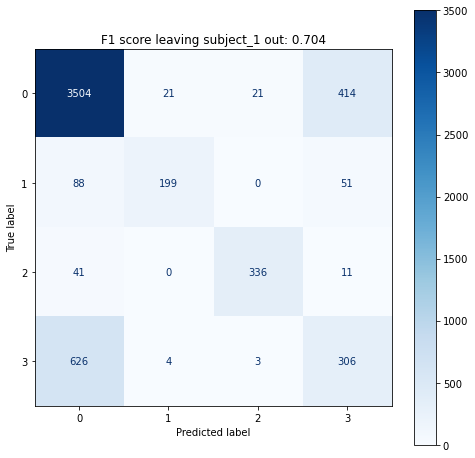

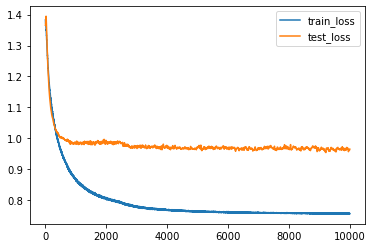

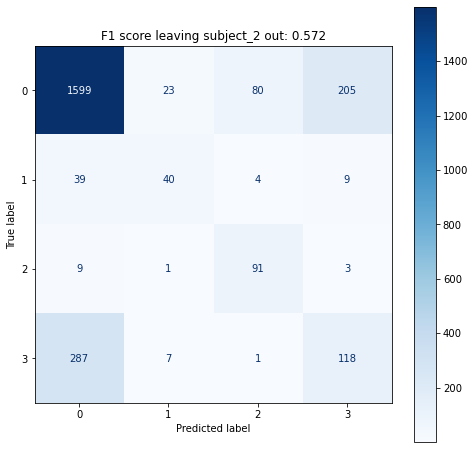

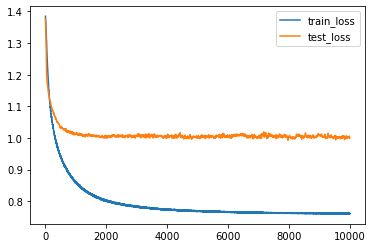

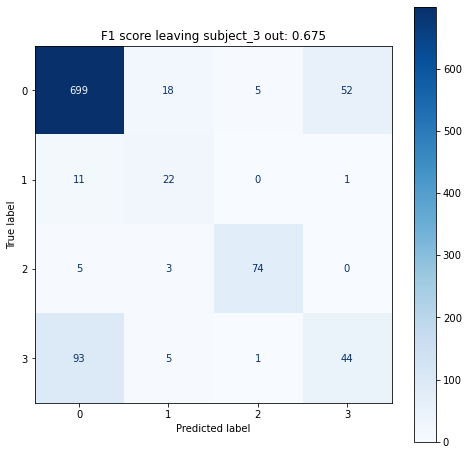

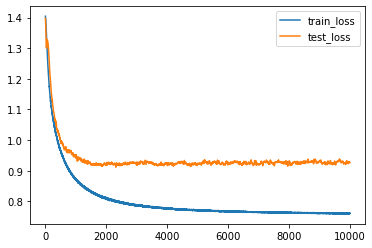

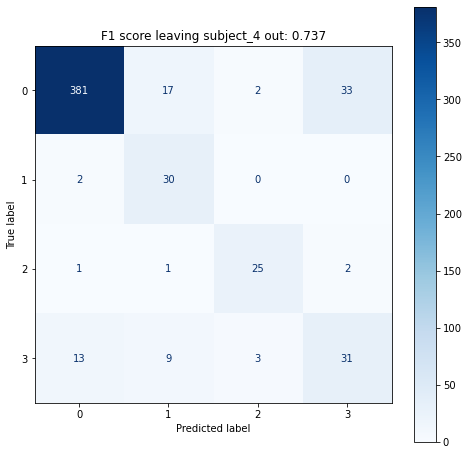

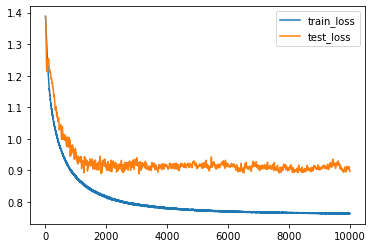

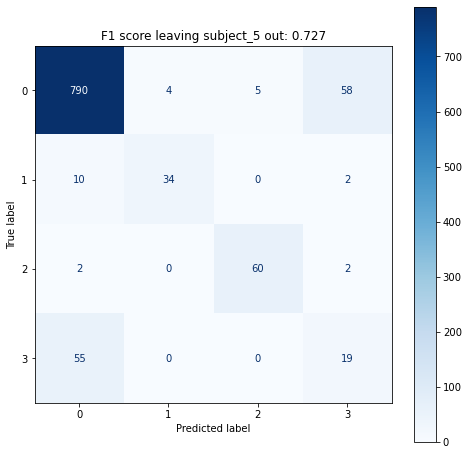

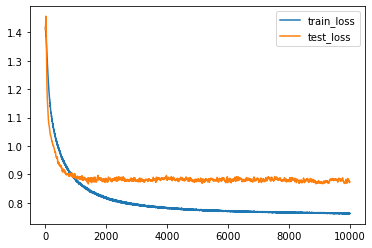

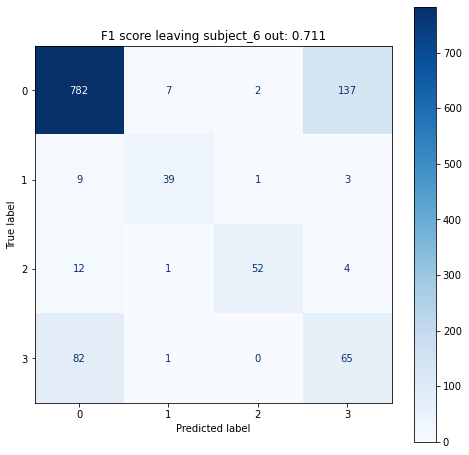

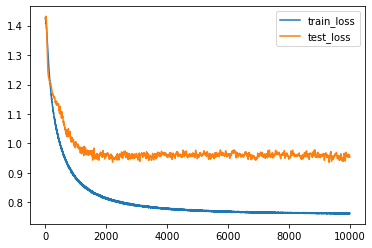

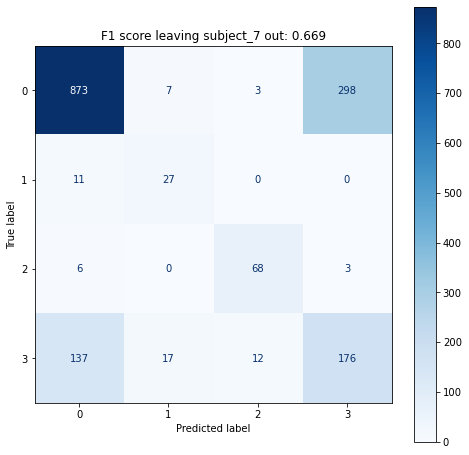

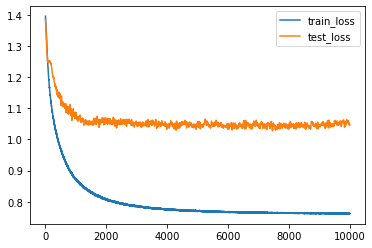

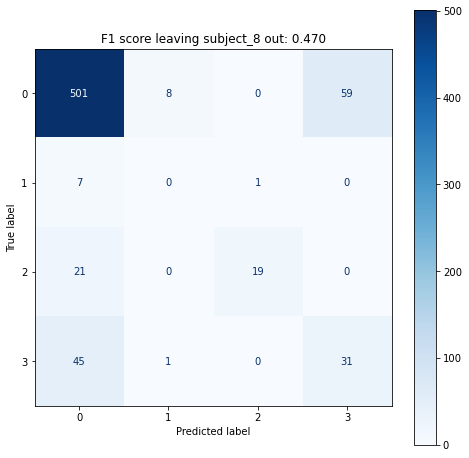

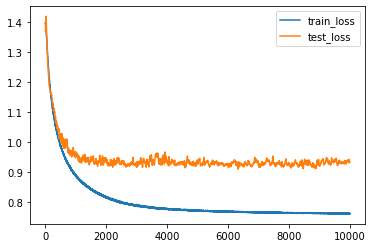

In [16]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

list_dfhist, list_minLoss, list_bestModel = [], [], []

for i in range(1, 9):

    keyval = f'subject_{i}'
    print(f'************************* Leaving {keyval} out *************************')

    dfsum_bal2 = dfsum_bal.drop([keyval], axis = 0)
    weights_bal = torch.from_numpy((dfsum_bal2.sum()/dfsum_bal2.sum().sum()).values).to(torch.float32)

    dfXtr = dfX_sc[dfX_sc['subject'] != keyval]
    dfytr = dfy.loc[dfXtr.index, :]

    dfXvl = dfX_sc[dfX_sc['subject'] == keyval]
    dfyvl = dfy.loc[dfXvl.index, :]

    Xtr = dfXtr.iloc[:, :-1].values.astype(float)
    ytr = dfytr.values

    Xvl = dfXvl.iloc[:, :-1].values.astype(float)
    yvl = dfyvl.values

    net = NetWrapper(10_000, learning_rate, device, weights_bal.to(device))
    dfhist, minLoss, bestModel = net.fit(Xtr, ytr, Xvl, yvl)
    list_dfhist.append(dfhist)
    list_minLoss.append(minLoss)
    list_bestModel.append(bestModel)

    pred = net.predict(Xvl).argmax(axis = 1)
    m = confusion_matrix(yvl, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (8, 8))
    disp.plot(ax = ax,  cmap = plt.cm.Blues)
    ax.set_title(f"F1 score leaving {keyval} out: {f1_score(pred, yvl, average='macro'):0.3f}")

    fig, ax = plt.subplots(figsize = (6, 4))
    dfhist.plot(ax = ax)

In [17]:
dfTest = []
i = 0
for k in dctTestSt.keys():
    aux = dctTestSt[k]
    aux.index = range(i, i + len(aux))
    i += len(aux)
    dfTest.append(aux)
dfTest = pd.concat(dfTest, axis = 0)

Xtest = dfTest.iloc[:, :-2]
Xtest_sc = scaler.transform(Xtest)
ytest = dfTest.iloc[:, -2].values

In [26]:
with open('scaler_model09.pkl', 'wb') as fout:
    pickle.dump(scaler, fout)

In [25]:
# # models = []
# for imod, mod in enumerate(list_bestModel):
#     # create a new instance of the model
#     model = Net()
#     # load saved weights
#     model.load_state_dict(mod)
#     wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
#     wrapper.model = model.to(device)
#     # put the model in evaluation mode
#     pred = wrapper.predict(Xtest_sc).argmax(axis = 1)
    
#     m = confusion_matrix(ytest, pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=m)
#     fig, ax = plt.subplots(figsize = (8, 8))
#     disp.plot(ax = ax,  cmap = plt.cm.Blues)
#     ax.set_title(f"F1 score leaving subject {imod + 1} out: {f1_score(pred, ytest, average='macro'):0.3f} - Test set")

Text(0.5, 1.0, 'F1 score with averaged probs: 0.742 - Test set')

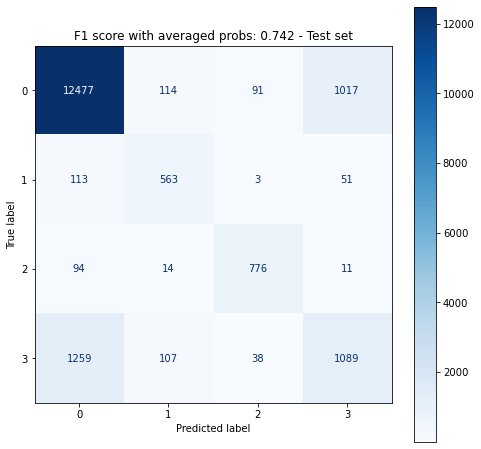

In [36]:
# average probabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = Path(r'/home/tacuevas/github/ECE542_NCSU_projC')
list_preds = []
list_bestModel = [torch.load(pin/x) for x in sorted([y for y in os.listdir(pin) if y.startswith('model09_r1_subject')])]
for imod, mod in enumerate(list_bestModel):
    # create a new instance of the model
    model = nn.DataParallel(Net())
    # load saved weights
    model.load_state_dict(mod)
    wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
    wrapper.model = model.to(device)
    # put the model in evaluation mode
    pred = wrapper.predict(Xtest_sc)
    list_preds.append(pred)
arr_preds = np.array(list_preds)

arr_preds_mean = np.mean(arr_preds, axis = 0)
preds_mean = np.argmax(arr_preds_mean, axis = 1)

m = confusion_matrix(ytest, preds_mean)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score with averaged probs: {f1_score(preds_mean, ytest, average='macro'):0.3f} - Test set")

In [131]:
# for imod, mod in enumerate(list_bestModel):
#     torch.save(mod, f'model09_subject_{imod+1}out_1e4epochs.pt')

In [37]:
# Predict session by session to then unwindow the predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = Path(r'/home/tacuevas/github/ECE542_NCSU_projC')
list_bestModel = [torch.load(pin/x) for x in sorted([y for y in os.listdir(pin) if y.startswith('model09_subject')])]

dctPredClass = {}
dctPredProbs = {}

for k in dctTestSt.keys():
    print(k)
    dfTestK = dctTestSt[k]

    dfTestFullK = dctTest[k]

    for s in dfTestK.iloc[:, -1].unique():
        print(s)
        dfTestKs = dfTestK[dfTestK[133] == s]

        dfTestFullK = dfTestFullK[dfTestFullK['session'] == s]

        list_preds = []
        for imod, mod in enumerate(list_bestModel):
            model = Net()
            model.load_state_dict(mod)
            wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
            wrapper.model = model.to(device)
            pred = wrapper.predict(scaler.transform(dfTestKs.iloc[:, :-2]))
            list_preds.append(pred)
        arr_preds = np.array(list_preds)
        mean_arr_preds = np.mean(arr_preds, axis = 0)
        predictedClass = np.argmax(mean_arr_preds, axis = 1)
        predictedProbs = np.max(mean_arr_preds, axis = 1)

        dctPredClass[f'{k}_session_{s}'] = predictedClass
        dctPredProbs[f'{k}_session_{s}'] = predictedProbs

subject_1
5
subject_2
2
subject_3
2
subject_4
1
subject_5
1
subject_6
2
subject_7
3


In [38]:
wlength = 75
overlapping = 50
aux = wlength - overlapping

arrClassAll = []
trueClassAll = []

for k in dctPredProbs.keys():
    print(k)
    subj = k.split('_sess')[0]
    sess = int(k.split('_')[-1])

    dfTestFullK = dctTest[subj]

    for sess in dfTestFullK['session'].unique():
        print(sess)
        dfTestFullKs = dfTestFullK[dfTestFullK['session'] == sess]
        
        #dfAuxProbs = pd.DataFrame(index = range(len(dfTestFullK)), columns = range(len(predictedClass)), data = -1)
        #dfAuxClass = dfAuxProbs.copy()
        arrProbs = np.full((len(dfTestFullK), len(predictedClass)), np.nan)
        arrClass = arrProbs.copy()
        
        for icol in range(arrProbs.shape[1]):
            if icol != arrProbs.shape[1] - 1:
                arrProbs[icol*aux: icol*aux + wlength, icol] = predictedProbs[icol]
                arrClass[icol*aux: icol*aux + wlength, icol] = predictedClass[icol]
            else:
                arrProbs[icol*aux:, icol] = [predictedProbs[icol]] * len(arrProbs[icol*aux:, -1])
                arrClass[icol*aux:, icol] = [predictedClass[icol]] * len(arrClass[icol*aux:, -1])

        colMaxProb = np.nanargmax(arrProbs, axis = 1)
        classMaxProb = [arrClass[i, colMaxProb[i]] for i in range(len(arrClass))]#arrClass[np.arange(len(dfTestFullKs), colMaxProb)]
        arrClassAll.extend(classMaxProb)

subject_1_session_5
5
subject_2_session_2
2
subject_3_session_2
2
subject_4_session_1
1
subject_5_session_1
1
subject_6_session_2
2
subject_7_session_3
3


In [39]:
len(arrClassAll)

356323

In [40]:
dfTestAll = []
for k in dctTest.keys():
    aux = dctTest[k]
    aux.index = range(i, i + len(aux))
    i += len(aux)
    dfTestAll.append(aux)
dfTestAll = pd.concat(dfTestAll, axis = 0)
print(len(dfTestAll))

356323


In [41]:
dfTestAll

,accx,accy,accz,gyrox,gyroy,gyroz,session,time,class,class_time
17817,1.883375,9.517874,0.350562,0.012344,-0.003333,-0.006996,5,0.000,0,0.02
17818,2.003800,9.582067,0.313800,-0.007402,0.002363,-0.002316,5,0.025,0,0.02
17819,1.915998,9.582006,0.340000,-0.001517,-0.007236,-0.006531,5,0.050,0,0.02
17820,1.990245,9.482698,0.369264,-0.011702,0.000000,-0.005981,5,0.075,0,0.12
17821,2.028900,9.744136,0.359267,-0.021669,-0.009513,-0.007014,5,0.100,0,0.12
...,...,...,...,...,...,...,...,...,...,...
374135,0.616364,9.143636,3.423409,0.000120,0.006974,0.005248,3,1115.900,0,1115.92
374136,0.601402,9.160000,3.477195,0.002322,0.007574,0.008485,3,1115.925,0,1115.92
374137,0.551165,9.193496,3.477669,0.006486,0.000331,0.003153,3,1115.950,0,1115.92
374138,0.548438,9.160000,3.440781,-0.001079,-0.005426,-0.000032,3,1115.975,0,1115.92


Text(0.5, 1.0, 'F1 score with averaged probs: 0.272 - Test set')

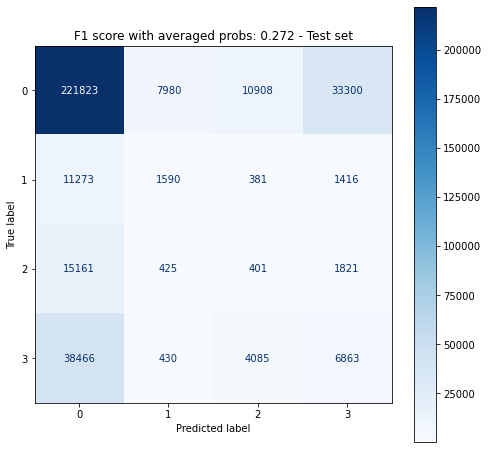

In [42]:
m = confusion_matrix(dfTestAll['class'].values, arrClassAll)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score with averaged probs: {f1_score(arrClassAll, dfTestAll['class'].values, average='macro'):0.3f} - Test set")

In [36]:
# arr_preds_max = np.max(arr_preds, axis = 0)
# preds_max = np.argmax(arr_preds_max, axis = 1)
# m = confusion_matrix(ytest, preds_mean)
# disp = ConfusionMatrixDisplay(confusion_matrix=m)
# fig, ax = plt.subplots(figsize = (8, 8))
# disp.plot(ax = ax,  cmap = plt.cm.Blues)
# ax.set_title(f"F1 score taking max prob: {f1_score(preds_max, ytest, average='macro'):0.3f} - Test set")

### Predict for the grading test set

In [7]:
def read_data_testing(pathin):
    ''''''
    # Define the header names for the 'x' CSV files
    x_header = ["accx", "accy", "accz", "gyrox", "gyroy", "gyroz"]
    # Define the header names for the 'x_time' CSV files
    x_time_header = ["seconds"]

    # Define the header names for the 'y' CSV files
    # y_header = ["class"]

    # Define the header names for the 'y_time' CSV files
    y_time_header = ["seconds"]

    # Create an empty list to store the dataframes
    dct = {}

    filesAll = [x for x in os.listdir(pathin) if x.endswith('.csv')]

    nSubjects = 4

    for i in range(9, 13):
        files = sorted([x for x in filesAll if x.startswith(f'subject_{i:03d}')])
        nSessions = int(len(files)/3) ## 4 files per session
        
        xdataAll = []
        ydataAll = []

        for j in range(nSessions):
            xdata = pd.read_csv(pathin/f'subject_{i:03d}_{j+1:02d}__x.csv', header = None, names = x_header)
            xdata['session'] = [j+1]*len(xdata)
            xtime = pd.read_csv(pathin/f'subject_{i:03d}_{j+1:02d}__x_time.csv', header = None, names = x_time_header)
            xdata['time'] = xtime['seconds'].values
            xdataAll.append(xdata)

            # ydata = pd.read_csv(pathin/f'subject_{i+1:03d}_{j+1:02d}__y.csv', header = None, names = y_header)
            # ydata['session'] = [j+1]*len(ydata)
            ytime = pd.read_csv(pathin/f'subject_{i:03d}_{j+1:02d}__y_time.csv', header = None, names = y_time_header)
            # ydata['time'] = ytime['seconds'].values
            ydataAll.append(ytime)

        dfx = pd.concat(xdataAll)
        dfx.index = range(len(dfx))
        dfy = pd.concat(ydataAll)
        dfy.index = range(len(dfy))

        dct[f'subject_{i}_x'] = dfx
        dct[f'subject_{i}_y'] = dfy
    return dct

In [8]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathTest = Path(r'./TestData')
dctTestData = read_data_testing(pathTest)

In [9]:
## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 75
overlapping = 50

dctGradingSt = {}
for k in dctTestData.keys():

    if k.endswith('_x'):
        df = dctTestData[k]
        list2 = []
        ## loop through sessions
        for s in df['session'].unique():
            dfs = df[df['session'] == s]
            for i in range(0, len(dfs) - overlapping, wlength - overlapping):
                dfss = dfs.iloc[i:i + wlength]
                dfssfft = pd.DataFrame(index = dfss.index, data = np.abs(np.fft.fft(dfss.iloc[:, :6])))
                dfss = pd.concat([dfss, dfssfft], axis = 1)
                # dfssClass = dfss[['class']]
                dfss = dfss.drop(['session', 'time'], axis = 1)
                list1 = []
                for ic, c in enumerate(dfss.columns):
                    dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                    list1.extend(dummy)
                list2.append(list1)
        dctGradingSt[k] = pd.DataFrame(data = list2)

In [10]:
dfGrading = []
i = 0
for k in dctGradingSt.keys():
    aux = dctGradingSt[k]
    aux.index = range(i, i + len(aux))
    i += len(aux)
    dfGrading.append(aux)
dfGrading = pd.concat(dfGrading, axis = 0)

Xgrad_sc = scaler.transform(dfGrading)

NameError: name 'scaler' is not defined

In [116]:
# average probabilities
list_preds = []
for imod, mod in enumerate(list_bestModel):
    # create a new instance of the model
    model = Net()
    # load saved weights
    model.load_state_dict(mod)
    wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
    wrapper.model = model.to(device)
    # put the model in evaluation mode
    pred = wrapper.predict(Xgrad_sc)
    list_preds.append(pred)
arr_preds = np.array(list_preds)

arr_preds_mean = np.mean(arr_preds, axis = 0)
preds_mean = np.argmax(arr_preds_mean, axis = 1)
preds_mean_probs = np.max(arr_preds_mean, axis = 1)

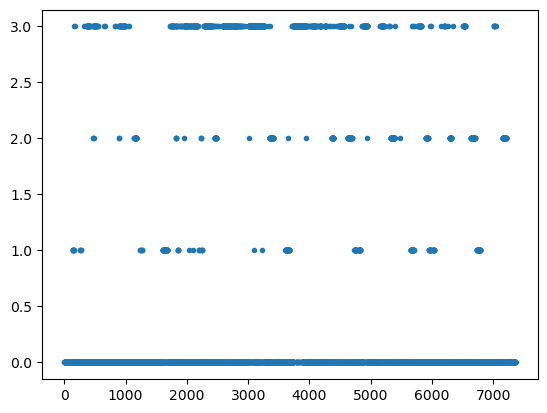

In [117]:
plt.plot(preds_mean, '.')

In [118]:
dctTestData

7360

In [126]:
dfGradingAll = []
i = 0
for k in dctTestData.keys():

    if k.endswith('_x'):
        aux = dctTestData[k].copy()
        aux.index = range(i, i + len(aux))
        i += len(aux)
        dfGradingAll.append(aux)
dfGradingAll = pd.concat(dfGradingAll, axis = 0)

In [127]:
dfGradingAll

,accx,accy,accz,gyrox,gyroy,gyroz,session,time
0,0.396845,8.710000,-4.476044,0.001111,-0.008889,0.004137,1,0.000
1,0.413795,8.706898,-4.456205,0.000000,-0.002838,0.007162,1,0.025
2,0.423914,8.707828,-4.502172,0.002037,0.001111,0.007778,1,0.050
3,0.442980,8.718078,-4.502980,0.000403,0.004648,0.008384,1,0.075
4,0.485234,8.725234,-4.520000,-0.000020,0.006667,0.007778,1,0.100
...,...,...,...,...,...,...,...,...
184147,1.759771,9.145114,3.150458,-0.006046,0.009510,0.035375,1,1132.850
184148,1.793038,9.156304,3.145874,-0.003333,0.010000,0.051222,1,1132.875
184149,1.885642,9.121285,3.091285,-0.005124,0.022902,0.063333,1,1132.900
184150,1.864490,9.156898,3.117592,-0.006667,0.017093,0.065642,1,1132.925


In [130]:
dctTestData['subject_9_x']

,accx,accy,accz,gyrox,gyroy,gyroz,session,time
0,0.396845,8.710000,-4.476044,0.001111,-0.008889,0.004137,1,0.000
1,0.413795,8.706898,-4.456205,0.000000,-0.002838,0.007162,1,0.025
2,0.423914,8.707828,-4.502172,0.002037,0.001111,0.007778,1,0.050
3,0.442980,8.718078,-4.502980,0.000403,0.004648,0.008384,1,0.075
4,0.485234,8.725234,-4.520000,-0.000020,0.006667,0.007778,1,0.100
...,...,...,...,...,...,...,...,...
37986,0.930160,9.009839,-3.756774,0.000203,0.000706,0.003739,1,949.650
37987,0.955662,8.983775,-3.763775,-0.001557,0.001610,0.001111,1,949.675
37988,0.930297,9.000000,-3.750178,0.001963,0.002815,0.001629,1,949.700
37989,0.965183,9.015183,-3.780000,0.001557,-0.000111,0.002334,1,949.725


In [129]:
dctTestData['subject_9_y']

,seconds
37991,0.02
37992,0.12
37993,0.22
37994,0.32
37995,0.42
...,...
47484,949.32
47485,949.42
47486,949.52
47487,949.62
